In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dlmia-hw05-test/train.csv
/kaggle/input/dlmia-hw05-test/test.csv
/kaggle/input/dlmia-hw05-test/test_images/029.jpg
/kaggle/input/dlmia-hw05-test/test_images/014.jpg
/kaggle/input/dlmia-hw05-test/test_images/109.jpg
/kaggle/input/dlmia-hw05-test/test_images/034.jpg
/kaggle/input/dlmia-hw05-test/test_images/024.jpg
/kaggle/input/dlmia-hw05-test/test_images/033.jpg
/kaggle/input/dlmia-hw05-test/test_images/094.jpg
/kaggle/input/dlmia-hw05-test/test_images/049.jpg
/kaggle/input/dlmia-hw05-test/test_images/048.jpg
/kaggle/input/dlmia-hw05-test/test_images/080.jpg
/kaggle/input/dlmia-hw05-test/test_images/062.jpg
/kaggle/input/dlmia-hw05-test/test_images/067.jpg
/kaggle/input/dlmia-hw05-test/test_images/106.jpg
/kaggle/input/dlmia-hw05-test/test_images/113.jpg
/kaggle/input/dlmia-hw05-test/test_images/006.jpg
/kaggle/input/dlmia-hw05-test/test_images/066.jpg
/kaggle/input/dlmia-hw05-test/test_images/011.jpg
/kaggle/input/dlmia-hw05-test/test_images/002.jpg
/kaggle/input/dlmia-h

In [2]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import random
import numpy as np
import pandas as pd
import math
from tqdm.notebook import tqdm

# visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# PyTorch
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.tv_tensors import BoundingBoxes

# object detection
!pip install pycocotools
import pycocotools
from pycocotools.coco import COCO

In [3]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
    
from engine import evaluate

--2024-12-25 07:46:23--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.97K  --.-KB/s    in 0s      

2024-12-25 07:46:23 (57.2 MB/s) - ‘engine.py’ saved [4063/4063]

--2024-12-25 07:46:24--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

In [11]:
## TODO: Prepare your own information
class config:
    
    ## roots for training & valid
    root = "/kaggle/input/dlmia-hw05-new"
    info_root = "/kaggle/input/dlmia-hw05-new"
    save_root = "/kaggle/working/"

    ## for test images
    test_root = '/kaggle/input/dlmia-hw05-test'
    info_root_test = '/kaggle/input/dlmia-hw05-test'
    
    num_classes = 8 #(for fasterrcnn: background + # of classes): 1+7=8
    
    
    batch_size = 4        
    epochs = 18           
    weight_decay = 1e-4   
    lr = 3e-3             
    momentum = 0.9        
    seed = 42             
    workers = 4           
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
def seed_everything(seed):
   
    random.seed(seed) # Set Python random seed    
    np.random.seed(seed) # Set NumPy random seed    
    torch.manual_seed(seed) # Set PyTorch random seed for CPU and GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    
seed_everything(config.seed)

In [6]:
annfile = config.info_root + "/train.json"
coco = COCO(annfile)
coco.cats

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{1: {'id': 1, 'name': 'aortic_curvature'},
 2: {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 3: {'id': 3, 'name': 'cardiac_hypertrophy'},
 4: {'id': 4, 'name': 'intercostal_pleural_thickening'},
 5: {'id': 5, 'name': 'lung_field_infiltration'},
 6: {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 7: {'id': 7, 'name': 'scoliosis'}}

In [7]:
coco.loadImgs(0)

[{'file_name': 'normal/220_94.jpg', 'height': 2560, 'width': 2472, 'id': 0}]

In [8]:
ann_ids = coco.getAnnIds(imgIds = 0)
coco.loadAnns(ann_ids)

[]

In [9]:
ann_ids = coco.getAnnIds(imgIds = 155)
coco.loadAnns(ann_ids)

[{'id': 163,
  'image_id': 155,
  'category_id': 3,
  'bbox': [816, 936, 1048, 896],
  'area': 939008,
  'iscrowd': 0,
  'segmentation': [[816, 936, 1864, 936, 1864, 1832, 816, 1832]]},
 {'id': 164,
  'image_id': 155,
  'category_id': 5,
  'bbox': [144, 336, 2008, 1941],
  'area': 3897528,
  'iscrowd': 0,
  'segmentation': [[144, 336, 2152, 336, 2152, 2277, 144, 2277]]}]

In [10]:
del coco

In [15]:
import torch
from torchvision.transforms import v2
from torchvision import tv_tensors

class medTransform:
    def __init__(self, train=False):
        if train:
            
            self.transforms = v2.Compose(
                [
                    v2.ToImage(),                  
                    v2.RandomRotation(degrees=5),  
                    v2.ColorJitter(
                        brightness=0.2,            
                        contrast=0.2,              
                        saturation=0.0,            
                        hue=0.0
                    ),
                    v2.ToDtype(torch.float32, scale=True),  
                ]
            )
        else:
            self.transforms = v2.Compose(
                [
                    v2.ToImage(),
                    v2.ToDtype(torch.float32, scale=True),
                ]
            )

    def __call__(self, x, bboxes):
        
        if isinstance(x, torch.Tensor):
            
            height, width = x.shape[-2], x.shape[-1]
        else:
            
            width, height = x.size

        
        bboxes = tv_tensors.BoundingBoxes(
            bboxes,
            format="XYWH",
            canvas_size=(height, width)
        )
        
        return self.transforms(x, bboxes)


In [13]:
class MedDataset(Dataset):
    
    def __init__(self, root, info_root, split, transforms = None):
        self.split = split
        self.root = root
        self.info_root = info_root
        self.transforms = transforms
        self.coco = COCO(os.path.join(self.info_root, f"{self.split}.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
    
    def get_image(self, img_id: int):
        image_path = os.path.join(self.root,self.coco.loadImgs(img_id)[0]['file_name'])
        image = Image.open(image_path).convert("RGB")
        return image

    def get_annotation(self, img_id: int):        
        return self.coco.loadAnns(self.coco.getAnnIds(img_id))
          
    def __getitem__(self, index):
        normal = False
        img_id = self.ids[index]
        image = self.get_image(img_id) 
        annotation = self.get_annotation(img_id)
        
        bboxes = [a['bbox']  for a in annotation]
        category_ids = [a['category_id']  for a in annotation]
        if bboxes == []:
            normal = True     
            
        if self.transforms:
            image, bboxes = self.transforms(image, bboxes)     
            
        def reformat_bboxes(boxes):
            return [[val[0], val[1], val[0] + val[2], val[1] + val[3]] for val in boxes]
        
        if normal != True:
            ## Recall that the original format is COCO
            bboxes = reformat_bboxes(bboxes)   

        def create_target(bboxes, normal):
            if normal:
                return {
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),  # Empty boxes
                    'labels': torch.tensor(category_ids, dtype=torch.int64),
                    'image_id': img_id,
                    'area': torch.zeros((0,), dtype=torch.float32),  # Empty areas
                    'iscrowd': torch.zeros((0,), dtype=torch.int64),  # Empty tensor for iscrowd
                }
            else:
            
                return {
                    'boxes': torch.tensor(bboxes),
                    'labels': torch.tensor(category_ids, dtype=torch.int64),
                    'image_id': img_id,
                    'area': torch.tensor([(bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) for bbox in bboxes], dtype=torch.float32),
                    'iscrowd': torch.tensor([a['iscrowd'] for a in annotation], dtype=torch.int64)
                }
       
        targets = create_target(bboxes,normal)
        return image, targets
        
    def __len__(self):
        return len(self.ids)

In [14]:
def collate_fn(batch: list[torch.tensor, dict]):
    return tuple(zip(*batch))

In [16]:
def plot_image_with_boxes(image_tensor, boxes_dict):
    image_np = image_tensor.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(image_np)
    for box in boxes_dict['boxes']:
        # Extract coordinates (x0, y0, x1, y1)
        x0, y0, x1, y1 = box
        # Calculate the height as (y0 - y1) since y0 is the top and y1 is the bottom
        height = y1 - y0
        # Create a rectangle patch with (x0, y0) as the top-left corner
        rect = patches.Rectangle((x0, y0), x1 - x0, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [17]:
train_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "train", transforms = medTransform(train=True))
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True,num_workers=4, collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


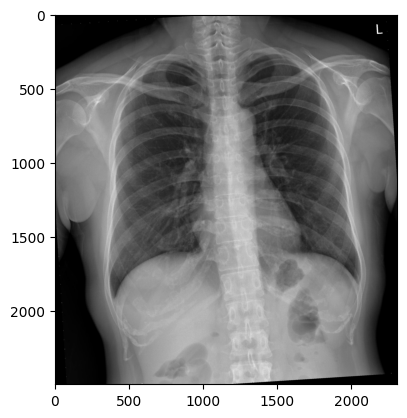

In [20]:
a,b = train_dataset.__getitem__(1)
plot_image_with_boxes(a,b)

{'boxes': tensor([[ 790,  922, 1875, 1861],
        [ 100,  294, 2188, 2318]]), 'labels': tensor([3, 5]), 'image_id': 155, 'area': tensor([1018815., 4226112.]), 'iscrowd': tensor([0, 0])}


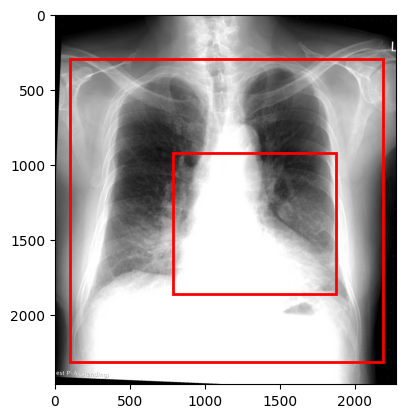

In [19]:
a,b = train_dataset.__getitem__(155)
print(b)
plot_image_with_boxes(a,b)

In [21]:
def fasterrcnn(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1') 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = None
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [22]:
model = fasterrcnn(config.num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 192MB/s] 


In [23]:
def train_one_epoch(model, train_loader, optimizer, epoch, device):
    model.train()
    
    train_loss = []
    train_loss_dict = []
    
    lr_scheduler = None

    for images, targets in tqdm(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        batch_loss_value = losses.item()
        batch_loss_dict = {k: v.item() for k, v in loss_dict.items()}

        train_loss.append(batch_loss_value)
        train_loss_dict.append(batch_loss_dict)
      
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
        if lr_scheduler is not None:
            lr_scheduler.step()
        
    train_loss = np.mean(train_loss)    
    train_loss_dict = pd.DataFrame(train_loss_dict).mean()
    train_loss_classifier = train_loss_dict.loss_classifier
    train_loss_box_reg = train_loss_dict.loss_box_reg
    train_loss_rpn_box_reg = train_loss_dict.loss_rpn_box_reg
    train_loss_objectness = train_loss_dict.loss_objectness

    return train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness

In [24]:
def validation(model, val_loader, device):
    model.train()
    #model.eval()
    for m in model.modules():
        if isinstance(m, torchvision.ops.Conv2dNormActivation):
            m.eval()
        if isinstance(m, torchvision.ops.FrozenBatchNorm2d):
            m.eval()
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()
    val_loss = []
    val_loss_dict = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images = [image.to(device) for image in images]
            targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

            loss = model(images, targets)
            total_loss = sum(l for l in loss.values())
            
            loss_value = total_loss.item()
            loss_dict = {k: v.item() for k, v in loss.items()}
            
            val_loss.append(loss_value)
            val_loss_dict.append(loss_dict)
    
    val_loss = np.mean(val_loss)
    
    val_loss_dict = pd.DataFrame(val_loss_dict).mean()
    val_loss_classifier = val_loss_dict.loss_classifier
    val_loss_box_reg = val_loss_dict.loss_box_reg
    val_loss_rpn_box_reg = val_loss_dict.loss_rpn_box_reg
    val_loss_objectness = val_loss_dict.loss_objectness
    
    return val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness

In [25]:
del model
del train_dataset, train_loader

In [26]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [27]:
def main():
    
    seed_everything(config.seed)    
    g = torch.Generator()
    g.manual_seed(config.seed)
    
    train_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "train", transforms = medTransform(train=True))
    val_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "val",  transforms = medTransform(train=False))

    train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True,
                              num_workers=config.workers, collate_fn = collate_fn,pin_memory=True
                             )
    val_loader = DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False,
                            num_workers=config.workers, worker_init_fn=seed_worker,
                            generator=g, collate_fn = collate_fn,pin_memory=True
                           )

    
    device = config.device
    model =  fasterrcnn(num_classes = config.num_classes)
    model.to(device)
    
    parameters = [p for p in model.parameters() if p.requires_grad]

    optimizer = torch.optim.SGD(parameters, lr = config.lr, momentum = config.momentum, nesterov = True, weight_decay = config.weight_decay)
    best_val_loss = float("inf")
    best_map50 = 0.0
    history = {
        "train": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "val": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "map50":{
            "train":[],
            "valid":[],
        }
    }
    best_idx = 0
    print('start')
    for epoch in range(config.epochs):
        print()
        train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness = train_one_epoch(
            model, train_loader, optimizer, epoch, device,
        )
        
        val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness = validation(
            model, val_loader, device
        )

        ## Training
        history["train"]["loss"].append(train_loss)
        history["train"]["loss_classifier"].append(train_loss_classifier)
        history["train"]["loss_box_reg"].append(train_loss_box_reg)
        history["train"]["loss_rpn_box_reg"].append(train_loss_rpn_box_reg)
        history["train"]["loss_objectness"].append(train_loss_objectness)
        ## Validation
        history["val"]["loss"].append(val_loss)
        history["val"]["loss_classifier"].append(val_loss_classifier)
        history["val"]["loss_box_reg"].append(val_loss_box_reg)
        history["val"]["loss_rpn_box_reg"].append(val_loss_rpn_box_reg)
        history["val"]["loss_objectness"].append(val_loss_objectness)

        
        print(f'Epoch: {epoch+1}/{config.epochs} | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        print("*****Training*****")
        print(f'Loss: {train_loss:.4f} | Classifier Loss: {train_loss_classifier:.4f} | Box Reg Loss: {train_loss_box_reg:.4f} | RPN Box Reg Loss: {train_loss_rpn_box_reg:.4f} | Objectness Loss: {train_loss_objectness:.4f}')
        train_evaluator = evaluate(model, train_loader, device = device)
        print("*****Validation*****")
        print(f'Loss: {val_loss:.4f} | Classifier Loss: {val_loss_classifier:.4f} | Box Reg Loss: {val_loss_box_reg:.4f} | RPN Box Reg Loss: {val_loss_rpn_box_reg:.4f} | Objectness Loss: {val_loss_objectness:.4f}')
        valid_evaluator = evaluate(model, val_loader, device = device)
        
        train_map50 = train_evaluator.coco_eval['bbox'].stats[1]
        valid_map50 = valid_evaluator.coco_eval['bbox'].stats[1]
        
        history["map50"]["train"].append(train_map50)   
        history["map50"]["valid"].append(valid_map50)        

        ## TODO save your model

        if valid_map50 > best_map50:
            best_map50 = valid_map50
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_idx=epoch
            
            torch.save(save_file, os.path.join(config.save_root,"final.pth"))
        
    print(f'Best epoch in {best_idx+1}') 


    ## Evaluation result 
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["map50"]["train"], label = 'Training map50')
    plt.plot(range(config.epochs), history["map50"]["valid"], label = 'Validation map50')
    plt.xlabel('Epoch')
    plt.ylabel('map')
    plt.legend()
    plt.title('Validation and Testing map50')
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config.epochs), history["val"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_classifier"], label = 'Training Classifier Loss')
    plt.plot(range(config.epochs), history["val"]["loss_classifier"], label = 'Validation Classifier Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Loss')
    plt.legend()
    plt.title('Training and Validation Classifier Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_box_reg"], label = 'Training Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_box_reg"], label = 'Validation Box Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation Box Reg Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_rpn_box_reg"], label = 'Training RPN Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_rpn_box_reg"], label = 'Validation RPN Box Reg Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('RPN Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation RPN Box Reg Loss Curves')
    plt.show()
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_objectness"], label = 'Training Objectness Loss')
    plt.plot(range(config.epochs), history["val"]["loss_objectness"], label = 'Validation Objectness Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Objectness Loss')
    plt.legend()
    plt.title('Training and Validation Objectness Loss Curves')
    plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
start



  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1/18 | LR: 0.003000
*****Training*****
Loss: 0.2848 | Classifier Loss: 0.1648 | Box Reg Loss: 0.0993 | RPN Box Reg Loss: 0.0088 | Objectness Loss: 0.0119
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:10  model_time: 0.3441 (0.3441)  evaluator_time: 0.0465 (0.0465)  time: 7.0115  data: 6.5975  max mem: 4823
Test:  [69/70]  eta: 0:00:01  model_time: 0.2344 (0.2408)  evaluator_time: 0.0164 (0.0183)  time: 1.4274  data: 1.1546  max mem: 4823
Test: Total time: 0:01:52 (1.6061 s / it)
Averaged stats: model_time: 0.2344 (0.2408)  evaluator_time: 0.0164 (0.0183)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2/18 | LR: 0.003000
*****Training*****
Loss: 0.2037 | Classifier Loss: 0.0966 | Box Reg Loss: 0.0956 | RPN Box Reg Loss: 0.0065 | Objectness Loss: 0.0050
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:44  model_time: 0.2610 (0.2610)  evaluator_time: 0.0114 (0.0114)  time: 7.4882  data: 7.1921  max mem: 4823
Test:  [69/70]  eta: 0:00:01  model_time: 0.2194 (0.2324)  evaluator_time: 0.0126 (0.0234)  time: 1.3026  data: 1.0434  max mem: 4823
Test: Total time: 0:01:50 (1.5745 s / it)
Averaged stats: model_time: 0.2194 (0.2324)  evaluator_time: 0.0126 (0.0234)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3/18 | LR: 0.003000
*****Training*****
Loss: 0.1790 | Classifier Loss: 0.0856 | Box Reg Loss: 0.0817 | RPN Box Reg Loss: 0.0064 | Objectness Loss: 0.0052
creating index...
index created!
Test:  [ 0/70]  eta: 0:07:27  model_time: 0.3605 (0.3605)  evaluator_time: 0.0294 (0.0294)  time: 6.3919  data: 5.9810  max mem: 4823
Test:  [69/70]  eta: 0:00:01  model_time: 0.2220 (0.2322)  evaluator_time: 0.0141 (0.0181)  time: 1.4244  data: 1.1699  max mem: 4823
Test: Total time: 0:01:51 (1.5920 s / it)
Averaged stats: model_time: 0.2220 (0.2322)  evaluator_time: 0.0141 (0.0181)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4/18 | LR: 0.003000
*****Training*****
Loss: 0.1490 | Classifier Loss: 0.0745 | Box Reg Loss: 0.0649 | RPN Box Reg Loss: 0.0057 | Objectness Loss: 0.0039
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:50  model_time: 0.3188 (0.3188)  evaluator_time: 0.0396 (0.0396)  time: 7.5771  data: 7.1853  max mem: 4823
Test:  [69/70]  eta: 0:00:01  model_time: 0.2202 (0.2303)  evaluator_time: 0.0100 (0.0221)  time: 1.3425  data: 1.0706  max mem: 4823
Test: Total time: 0:01:53 (1.6249 s / it)
Averaged stats: model_time: 0.2202 (0.2303)  evaluator_time: 0.0100 (0.0221)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5/18 | LR: 0.003000
*****Training*****
Loss: 0.1485 | Classifier Loss: 0.0740 | Box Reg Loss: 0.0647 | RPN Box Reg Loss: 0.0061 | Objectness Loss: 0.0036
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:56  model_time: 0.2447 (0.2447)  evaluator_time: 0.0190 (0.0190)  time: 7.6711  data: 7.3829  max mem: 4936
Test:  [69/70]  eta: 0:00:01  model_time: 0.2240 (0.2292)  evaluator_time: 0.0107 (0.0152)  time: 1.3438  data: 1.0951  max mem: 4936
Test: Total time: 0:01:48 (1.5517 s / it)
Averaged stats: model_time: 0.2240 (0.2292)  evaluator_time: 0.0107 (0.0152)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6/18 | LR: 0.003000
*****Training*****
Loss: 0.1384 | Classifier Loss: 0.0688 | Box Reg Loss: 0.0615 | RPN Box Reg Loss: 0.0052 | Objectness Loss: 0.0029
creating index...
index created!
Test:  [ 0/70]  eta: 0:09:22  model_time: 0.2947 (0.2947)  evaluator_time: 0.0179 (0.0179)  time: 8.0387  data: 7.7028  max mem: 4936
Test:  [69/70]  eta: 0:00:01  model_time: 0.2244 (0.2326)  evaluator_time: 0.0116 (0.0145)  time: 1.2743  data: 1.0111  max mem: 4936
Test: Total time: 0:01:50 (1.5842 s / it)
Averaged stats: model_time: 0.2244 (0.2326)  evaluator_time: 0.0116 (0.0145)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7/18 | LR: 0.003000
*****Training*****
Loss: 0.1338 | Classifier Loss: 0.0679 | Box Reg Loss: 0.0576 | RPN Box Reg Loss: 0.0049 | Objectness Loss: 0.0034
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:32  model_time: 0.3198 (0.3198)  evaluator_time: 0.0297 (0.0297)  time: 7.3275  data: 6.9516  max mem: 4936
Test:  [69/70]  eta: 0:00:01  model_time: 0.2241 (0.2347)  evaluator_time: 0.0117 (0.0169)  time: 1.2677  data: 1.0134  max mem: 4936
Test: Total time: 0:01:47 (1.5359 s / it)
Averaged stats: model_time: 0.2241 (0.2347)  evaluator_time: 0.0117 (0.0169)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8/18 | LR: 0.003000
*****Training*****
Loss: 0.1262 | Classifier Loss: 0.0644 | Box Reg Loss: 0.0544 | RPN Box Reg Loss: 0.0046 | Objectness Loss: 0.0027
creating index...
index created!
Test:  [ 0/70]  eta: 0:10:06  model_time: 0.2388 (0.2388)  evaluator_time: 0.0178 (0.0178)  time: 8.6694  data: 8.3857  max mem: 4936
Test:  [69/70]  eta: 0:00:01  model_time: 0.2196 (0.2257)  evaluator_time: 0.0102 (0.0132)  time: 1.3967  data: 1.1516  max mem: 4936
Test: Total time: 0:01:56 (1.6668 s / it)
Averaged stats: model_time: 0.2196 (0.2257)  evaluator_time: 0.0102 (0.0132)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9/18 | LR: 0.003000
*****Training*****
Loss: 0.1232 | Classifier Loss: 0.0626 | Box Reg Loss: 0.0531 | RPN Box Reg Loss: 0.0045 | Objectness Loss: 0.0031
creating index...
index created!
Test:  [ 0/70]  eta: 0:09:19  model_time: 0.2968 (0.2968)  evaluator_time: 0.0177 (0.0177)  time: 7.9905  data: 7.6444  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2254 (0.2353)  evaluator_time: 0.0111 (0.0218)  time: 1.4403  data: 1.1546  max mem: 5065
Test: Total time: 0:01:52 (1.6129 s / it)
Averaged stats: model_time: 0.2254 (0.2353)  evaluator_time: 0.0111 (0.0218)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10/18 | LR: 0.003000
*****Training*****
Loss: 0.1196 | Classifier Loss: 0.0607 | Box Reg Loss: 0.0515 | RPN Box Reg Loss: 0.0044 | Objectness Loss: 0.0030
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:10  model_time: 0.3063 (0.3063)  evaluator_time: 0.0290 (0.0290)  time: 7.0119  data: 6.6470  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2193 (0.2348)  evaluator_time: 0.0095 (0.0157)  time: 1.4068  data: 1.1565  max mem: 5065
Test: Total time: 0:01:50 (1.5720 s / it)
Averaged stats: model_time: 0.2193 (0.2348)  evaluator_time: 0.0095 (0.0157)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11/18 | LR: 0.003000
*****Training*****
Loss: 0.1158 | Classifier Loss: 0.0583 | Box Reg Loss: 0.0510 | RPN Box Reg Loss: 0.0042 | Objectness Loss: 0.0023
creating index...
index created!
Test:  [ 0/70]  eta: 0:07:44  model_time: 0.2676 (0.2676)  evaluator_time: 0.0169 (0.0169)  time: 6.6332  data: 6.3263  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2207 (0.2330)  evaluator_time: 0.0108 (0.0161)  time: 1.1881  data: 0.9320  max mem: 5065
Test: Total time: 0:01:49 (1.5686 s / it)
Averaged stats: model_time: 0.2207 (0.2330)  evaluator_time: 0.0108 (0.0161)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12/18 | LR: 0.003000
*****Training*****
Loss: 0.1126 | Classifier Loss: 0.0563 | Box Reg Loss: 0.0502 | RPN Box Reg Loss: 0.0041 | Objectness Loss: 0.0020
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:36  model_time: 0.2943 (0.2943)  evaluator_time: 0.0197 (0.0197)  time: 7.3830  data: 7.0410  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2236 (0.2348)  evaluator_time: 0.0100 (0.0217)  time: 1.2831  data: 1.0238  max mem: 5065
Test: Total time: 0:01:49 (1.5628 s / it)
Averaged stats: model_time: 0.2236 (0.2348)  evaluator_time: 0.0100 (0.0217)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13/18 | LR: 0.003000
*****Training*****
Loss: 0.1098 | Classifier Loss: 0.0551 | Box Reg Loss: 0.0485 | RPN Box Reg Loss: 0.0040 | Objectness Loss: 0.0022
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:42  model_time: 0.2748 (0.2748)  evaluator_time: 0.0175 (0.0175)  time: 7.4711  data: 7.1471  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2248 (0.2341)  evaluator_time: 0.0114 (0.0152)  time: 1.2850  data: 1.0291  max mem: 5065
Test: Total time: 0:01:42 (1.4639 s / it)
Averaged stats: model_time: 0.2248 (0.2341)  evaluator_time: 0.0114 (0.0152)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14/18 | LR: 0.003000
*****Training*****
Loss: 0.1039 | Classifier Loss: 0.0517 | Box Reg Loss: 0.0466 | RPN Box Reg Loss: 0.0036 | Objectness Loss: 0.0020
creating index...
index created!
Test:  [ 0/70]  eta: 0:07:38  model_time: 0.3803 (0.3803)  evaluator_time: 0.0538 (0.0538)  time: 6.5498  data: 6.0880  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2246 (0.2317)  evaluator_time: 0.0097 (0.0140)  time: 1.4072  data: 1.1530  max mem: 5065
Test: Total time: 0:01:47 (1.5423 s / it)
Averaged stats: model_time: 0.2246 (0.2317)  evaluator_time: 0.0097 (0.0140)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15/18 | LR: 0.003000
*****Training*****
Loss: 0.1007 | Classifier Loss: 0.0502 | Box Reg Loss: 0.0448 | RPN Box Reg Loss: 0.0036 | Objectness Loss: 0.0022
creating index...
index created!
Test:  [ 0/70]  eta: 0:09:40  model_time: 0.2572 (0.2572)  evaluator_time: 0.0415 (0.0415)  time: 8.2914  data: 7.9679  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2285 (0.2359)  evaluator_time: 0.0120 (0.0153)  time: 1.2588  data: 0.9932  max mem: 5065
Test: Total time: 0:01:46 (1.5258 s / it)
Averaged stats: model_time: 0.2285 (0.2359)  evaluator_time: 0.0120 (0.0153)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 16/18 | LR: 0.003000
*****Training*****
Loss: 0.0991 | Classifier Loss: 0.0486 | Box Reg Loss: 0.0449 | RPN Box Reg Loss: 0.0034 | Objectness Loss: 0.0022
creating index...
index created!
Test:  [ 0/70]  eta: 0:08:03  model_time: 0.3024 (0.3024)  evaluator_time: 0.0410 (0.0410)  time: 6.9130  data: 6.5433  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2165 (0.2325)  evaluator_time: 0.0086 (0.0139)  time: 1.3033  data: 1.0574  max mem: 5065
Test: Total time: 0:01:47 (1.5405 s / it)
Averaged stats: model_time: 0.2165 (0.2325)  evaluator_time: 0.0086 (0.0139)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.721
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17/18 | LR: 0.003000
*****Training*****
Loss: 0.0980 | Classifier Loss: 0.0475 | Box Reg Loss: 0.0452 | RPN Box Reg Loss: 0.0035 | Objectness Loss: 0.0019
creating index...
index created!
Test:  [ 0/70]  eta: 0:09:08  model_time: 0.2587 (0.2587)  evaluator_time: 0.0247 (0.0247)  time: 7.8346  data: 7.5238  max mem: 5065
Test:  [69/70]  eta: 0:00:01  model_time: 0.2239 (0.2354)  evaluator_time: 0.0104 (0.0143)  time: 1.4178  data: 1.1655  max mem: 5065
Test: Total time: 0:01:48 (1.5525 s / it)
Averaged stats: model_time: 0.2239 (0.2354)  evaluator_time: 0.0104 (0.0143)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18/18 | LR: 0.003000
*****Training*****
Loss: 0.0925 | Classifier Loss: 0.0440 | Box Reg Loss: 0.0430 | RPN Box Reg Loss: 0.0035 | Objectness Loss: 0.0019
creating index...
index created!
Test:  [ 0/70]  eta: 0:06:47  model_time: 0.2468 (0.2468)  evaluator_time: 0.0201 (0.0201)  time: 5.8202  data: 5.5294  max mem: 5206
Test:  [69/70]  eta: 0:00:01  model_time: 0.2280 (0.2321)  evaluator_time: 0.0093 (0.0121)  time: 1.3444  data: 1.0911  max mem: 5206
Test: Total time: 0:01:49 (1.5595 s / it)
Averaged stats: model_time: 0.2280 (0.2321)  evaluator_time: 0.0093 (0.0121)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

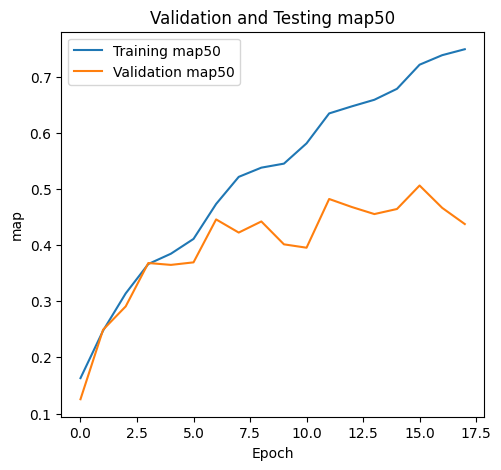

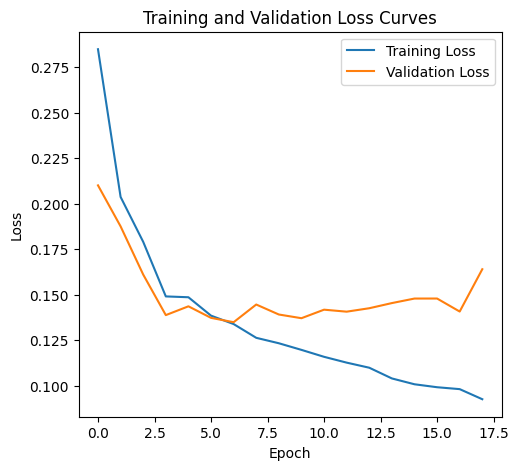

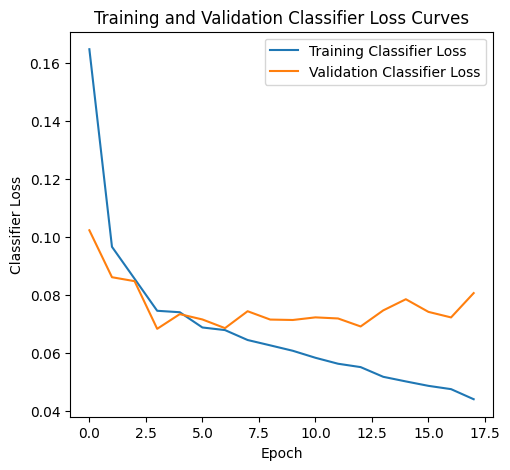

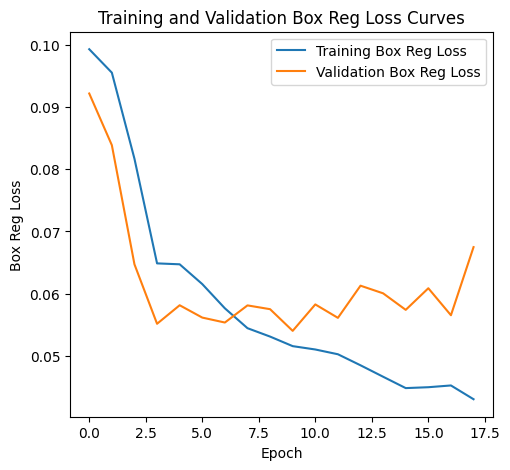

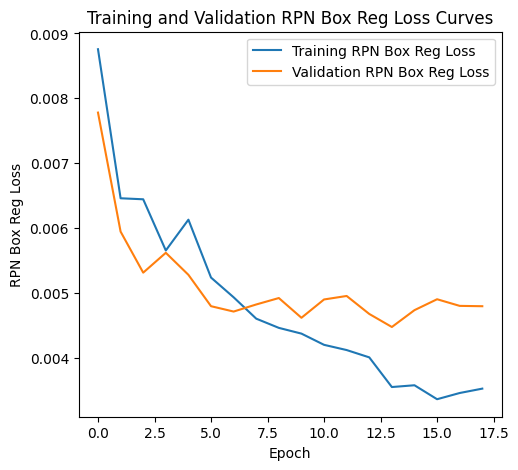

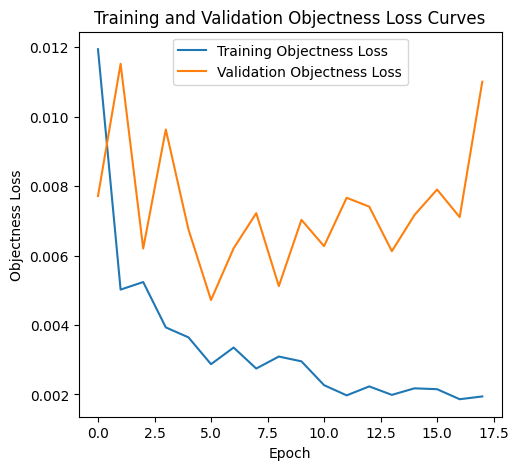

In [28]:
if __name__ == "__main__":
    main()

In [29]:
import os
import pandas as pd
import torch
from torchvision.transforms import functional as F
from tqdm.notebook import tqdm
from PIL import Image


class TestDataset:
    def __init__(self, root, info_root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.test_info = pd.read_csv(os.path.join(info_root, "test.csv"))

    def __len__(self):
        return len(self.test_info)

    def __getitem__(self, idx):
        
        file_name = self.test_info.iloc[idx]["Filename"]
        img_path = os.path.join(self.root, "test_images", file_name.replace(".dcm", ".jpg"))  # 確保對應到 .jpg
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        image = Image.open(img_path).convert("RGB")
        
        width = self.test_info.iloc[idx]["Width"]
        height = self.test_info.iloc[idx]["Height"]
        
        if self.transforms:
            image = self.transforms(image)
        
        
        return self.test_info.iloc[idx]["ID"], image, width, height


def inference_on_test_set(model, test_loader, device):
    model.eval()
    results = []
    
    with torch.no_grad():
        for img_ids, images, widths, heights in tqdm(test_loader):
            
            images = [img.to(device) for img in images]
            outputs = model(images)  # 得到 [ { 'boxes':..., 'labels':..., 'scores':... }, ... ]
            
            
            for img_id, output, img, w, h in zip(img_ids, outputs, images, widths, heights):
                w, h = float(w), float(h)  
                
                
                for box, label, score in zip(output["boxes"], 
                                             output["labels"], 
                                             output["scores"]):
                    if score < 0.5:  
                        continue
                    
                    
                    category = config.categories[label.item() - 1]
                    
                    
                    if category == "normal":
                        continue
                    
                    
                    xmin, ymin, xmax, ymax = box.tolist()
                    xmin, xmax = xmin / w, xmax / w
                    ymin, ymax = ymin / h, ymax / h
                    
                    
                    results.append({
                        "ID": img_id,
                        "category": category,
                        "score": score.item(),
                        "xmin": xmin,
                        "xmax": xmax,
                        "ymin": ymin,
                        "ymax": ymax
                    })
    return results


def save_results_to_csv(results, output_path):
    df = pd.DataFrame(results, columns=["ID","category","score","xmin","xmax","ymin","ymax"])
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")


def main():
    
    device = config.device

    
    model = fasterrcnn(num_classes=config.num_classes)
    
    
    checkpoint = torch.load(os.path.join(config.save_root, "final.pth"), map_location=device)
    model.load_state_dict(checkpoint["model"])
    model.to(device)

    
    test_dataset = TestDataset(
        root=config.test_root, 
        info_root=config.info_root_test,
        transforms=F.to_tensor
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))  
    )

    
    print("Running inference on test set...")
    results = inference_on_test_set(model, test_loader, device)

    
    output_csv = os.path.join(config.save_root, "submission.csv")
    save_results_to_csv(results, output_csv)

if __name__ == "__main__":
    
    class config:
        test_root = "/kaggle/input/dlmia-hw05-test"
        info_root_test = "/kaggle/input/dlmia-hw05-test"
        save_root = "/kaggle/working"
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        num_classes = 8
        categories = [
            "aortic_curvature",
            "aortic_atherosclerosis_calcification",
            "cardiac_hypertrophy",
            "intercostal_pleural_thickening",
            "lung_field_infiltration",
            "degenerative_joint_disease_of_the_thoracic",
            "scoliosis",
            "normal"
        ]
    
    main()


<ipython-input-29-359948ca1d9f>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(config.save_root, "final.pth"), map_location=device)


Running inference on test set...


  0%|          | 0/113 [00:00<?, ?it/s]

Results saved to /kaggle/working/submission.csv


In [30]:
import pandas as pd

submission_file = "/kaggle/working/submission.csv"  # 確保此路徑正確
pred_df = pd.read_csv(submission_file)

print("First 10 rows of predictions:")
print(pred_df.head(10))

print("\nLast 10 rows of predictions:")
print(pred_df.tail(10))

print("\nShape of the predictions DataFrame:")
print(pred_df.shape)


First 10 rows of predictions:
                      ID                                    category  \
0  TDR02_20161123_145314        aortic_atherosclerosis_calcification   
1  TDR02_20161123_145314  degenerative_joint_disease_of_the_thoracic   
2  TDR02_20161123_145314                     lung_field_infiltration   
3  TDR02_20161123_145314                            aortic_curvature   
4  TDR01_20171106_111727  degenerative_joint_disease_of_the_thoracic   
5  TDR01_20171106_111727                                   scoliosis   
6  TDR01_20180510_090210  degenerative_joint_disease_of_the_thoracic   
7  TDR01_20180510_090210                                   scoliosis   
8  TDR01_20180511_092549                                   scoliosis   
9  TDR01_20180511_092549  degenerative_joint_disease_of_the_thoracic   

      score      xmin      xmax      ymin      ymax  
0  0.719621  0.522589  0.668645  0.210334  0.404884  
1  0.696984  0.398186  0.679873  0.028602  0.768943  
2  0.687806  0.

In [31]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd

# visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
!pip install grad-cam
import pytorch_grad_cam
from pytorch_grad_cam import EigenCAM, AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

# PyTorch
import torch
import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=16c921b175d7f4d8ebd628bd038349d74158c096813c3ada961013169f755ba8
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [32]:
class config:
    
    root = "/kaggle/input/dlmia-hw05-new"
    num_classes = 8
    categories = ['normal', 'aortic_curvature', 'aortic_atherosclerosis_calcification', 
                  'cardiac_hypertrophy', 'intercostal_pleural_thickening', 'lung_field_infiltration', 
                  'degenerative_joint_disease_of_the_thoracic_spine', 'scoliosis']
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config.seed)

In [34]:
def fasterrcnn(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn()
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [35]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [config.categories[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices,scores = [], [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
            scores.append(pred_scores[index])
    boxes = np.int32(boxes)
    
    return boxes, classes, labels, indices, scores

COLORS = np.random.uniform(0, 255, size=(len(config.categories), 3))

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        # Convert RGB to BGR for OpenCV
        color = COLORS[labels[i]].astype(int)[::-1]
        
        # Draw the bounding box
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color.tolist(), 8
        )
        
        # Increase font size and thickness for label
        font_scale = 4 # Increase this value for larger font
        thickness = 10     # Increase thickness for better visibility
        
        # Add class label as text
        cv2.putText(image, classes[i], 
                    (int(box[0]), int(box[1]) - 10),  # Adjust text position
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    font_scale, 
                    color.tolist(), 
                    thickness,
                    lineType=cv2.LINE_AA)
    return image


In [36]:
def get_transform():
    
    transform = v2.Compose(
                [
                    v2.ToImage(), ## Used while using PIL image
                    #v2.ConvertBoundingBoxFormat(tv_tensors.BoundingBoxFormat.XYXY),
                    v2.ToDtype(torch.float32, scale=True),
                    
                ])       
    
    return transform

In [37]:
from torchvision.transforms.v2 import functional as F

In [38]:
def plot_eigen_cam_images(transforms, model, cat, threshold):
    rows, cols = 4, 2
    fig = plt.figure(figsize=(10, 20))  # Adjust figure size
    grid = plt.GridSpec(rows, cols)

    
    best_ckpt = torch.load("/kaggle/working/final.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config.device)
    target_layers = [model.backbone]

    cam = EigenCAM(
        model, 
        target_layers, 
        reshape_transform=fasterrcnn_reshape_transform
    )

    for i in range(rows * cols):
        
        all_images = os.listdir(os.path.join(config.root, config.categories[i]))        
        image_path = os.path.join(config.root, config.categories[i], all_images[0])
        image = Image.open(image_path).convert("RGB")   
        
        
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config.device)
        input_tensor = input_tensor.unsqueeze(0)
        image = np.array(image)
        image_float_np = np.float32(image) / 255

        
        boxes, classes, labels, indices, scores = predict(input_tensor, model, config.device, threshold)        
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
        
        
        grayscale_cam = cam(input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)

       
        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()

        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[i])
        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config.categories[i]}")
        ax.axis("off")

    
    fig.patch.set_facecolor('white')
    fig.suptitle("EigenCAM Images of 8 categories\n", fontweight='bold', size=16)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.4)  # Add extra space between plots


In [39]:
def plot_ablation_cam_images(transforms, model):
    
    rows, cols = 4, 2
    fig = plt.figure(figsize = (10, 20))
    grid = plt.GridSpec(rows, cols)
    
    best_ckpt = torch.load("/kaggle/working/final.pth", map_location = config.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config.device)
    target_layers = [model.backbone]
    
    cam = AblationCAM(model,
                      target_layers,
                      reshape_transform = fasterrcnn_reshape_transform,
                      ablation_layer = AblationLayerFasterRCNN(),
                      ratio_channels_to_ablate = 1.0)
    
    for i in range(rows * cols):
        
        all_images = os.listdir(os.path.join(config.root, config.categories[i]))
        image_path = os.path.join(config.root, config.categories[i], all_images[0])
        image = Image.open(image_path).convert("RGB")       
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config.device)
        input_tensor = input_tensor.unsqueeze(0)
        image = np.array(image)
        image_float_np = np.float32(image) / 255

        boxes, classes, labels, indices, scores = predict(input_tensor, model, config.device, 0)
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels = labels, bounding_boxes = boxes)]
        
        grayscale_cam = cam(input_tensor, targets = targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
        
        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()
        
        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = grid[i])
        
        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config.categories[i]}")
        ax.axis("off")
        
    fig.patch.set_facecolor('white')
    fig.suptitle("AblationCAM Images of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()

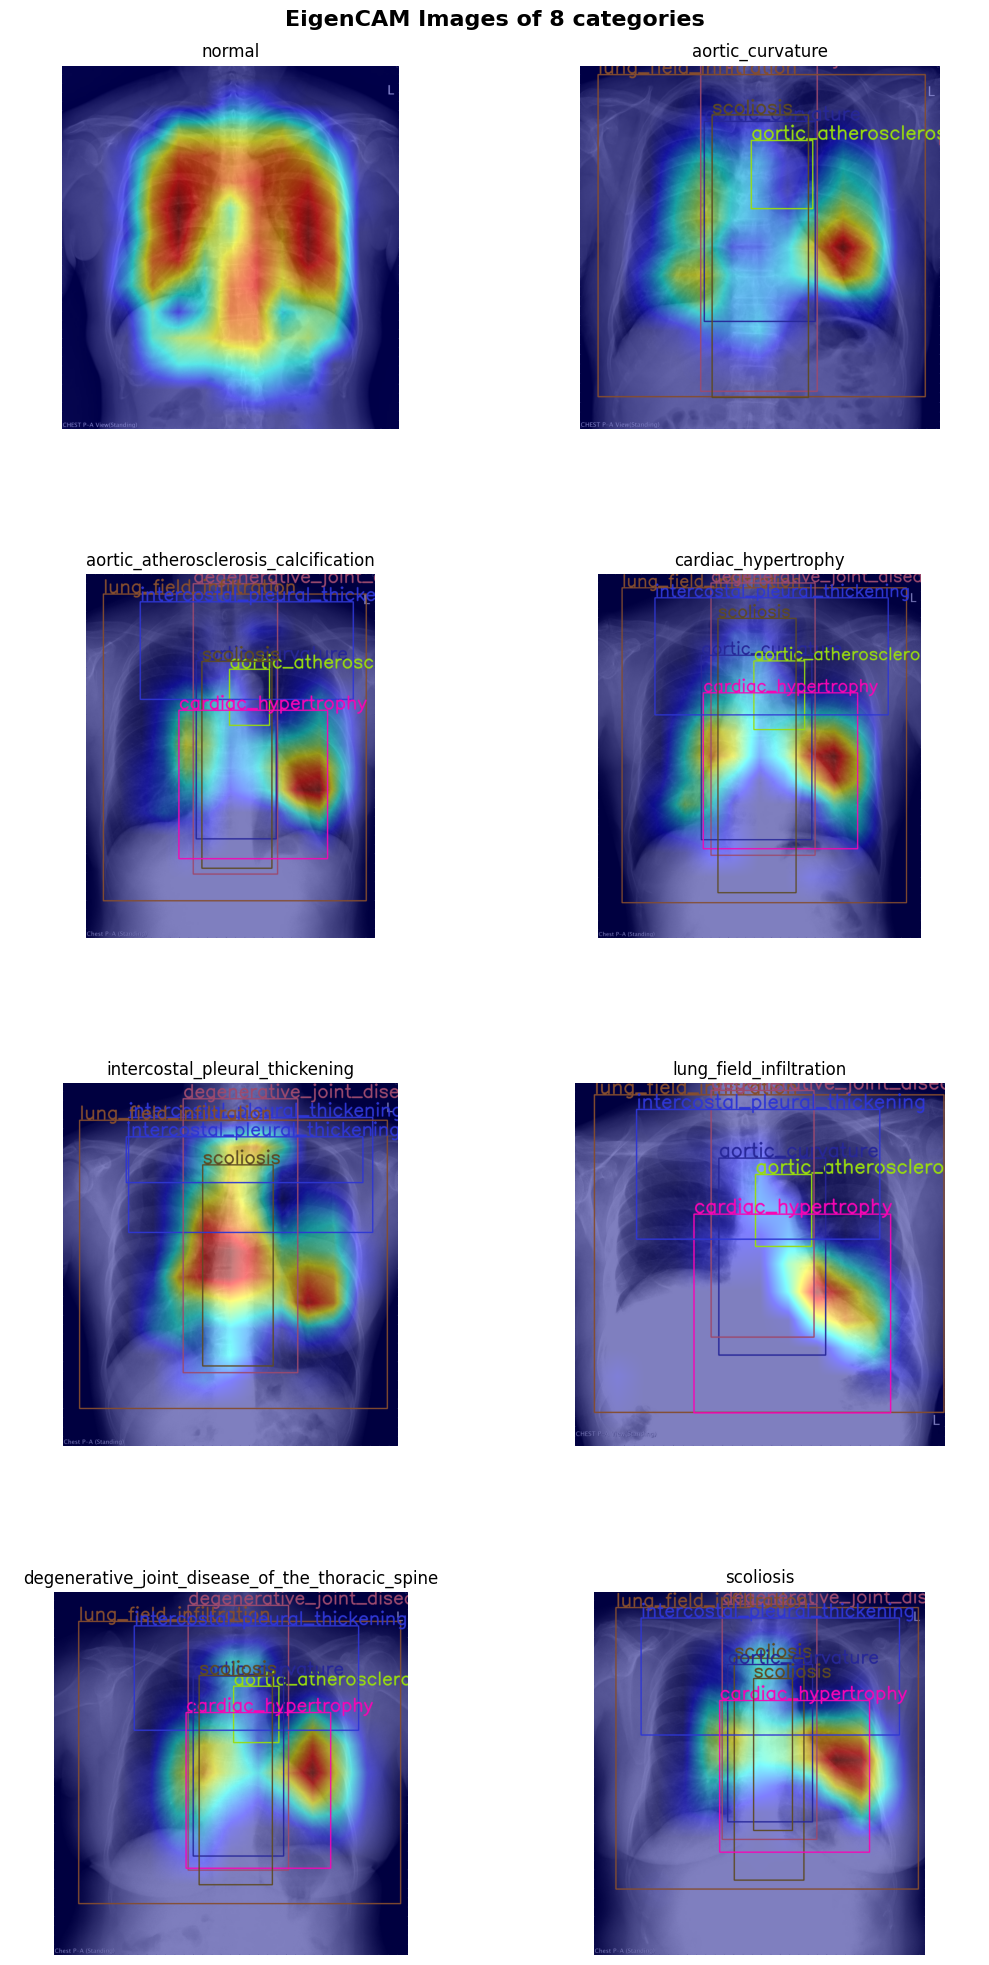

In [42]:
result = plot_eigen_cam_images(transforms = get_transform(), model = fasterrcnn(config.num_classes), cat=0, threshold=0)

100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


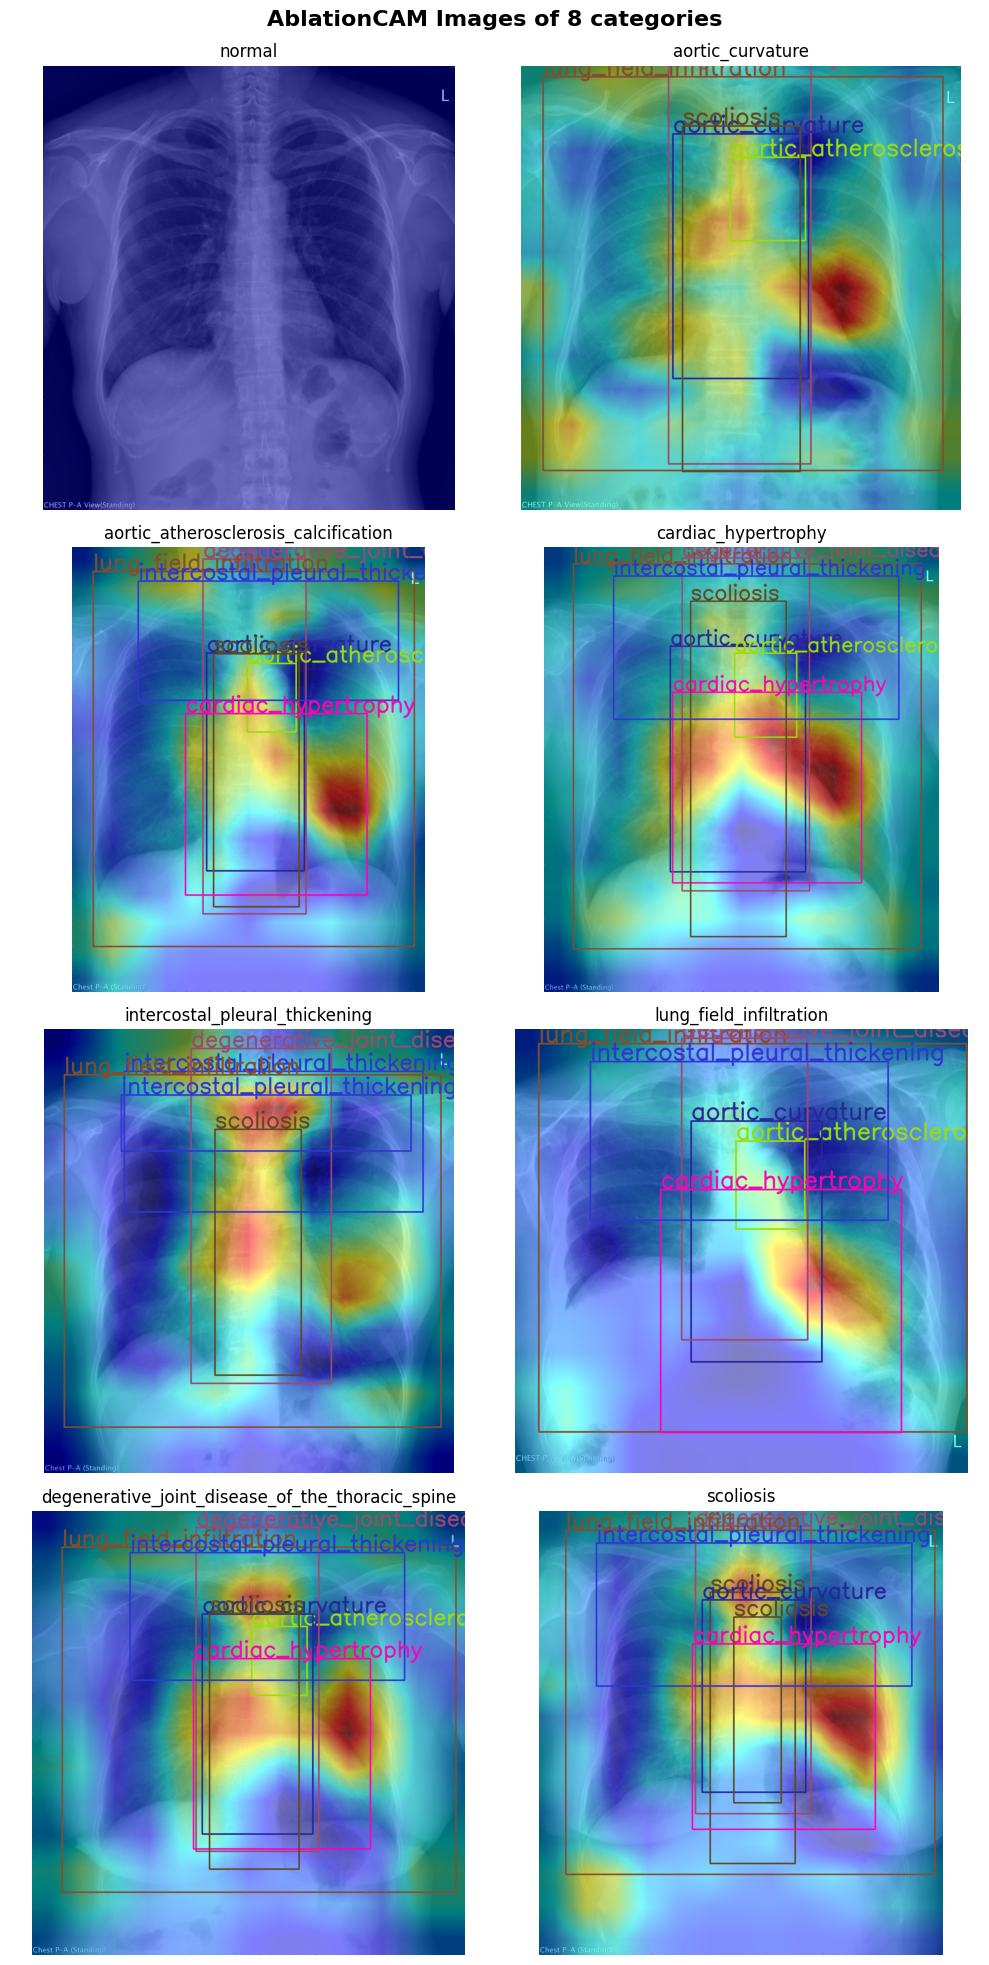

In [43]:
model = fasterrcnn(config.num_classes)
result_fig = plot_ablation_cam_images(
    transforms = get_transform(),
    model = model
)
